In [54]:
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
from colorit import *
init_colorit()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal

In [55]:
datafile = 'data.csv'
coint_prices = pd.read_csv(datafile,index_col = 'Date')
coint_prices.head(10)

,BABA,FB
Date,,
2018-01-02,183.649994,181.419998
2018-01-03,184.000000,184.669998
2018-01-04,185.710007,184.330002
2018-01-05,190.699997,186.850006
2018-01-08,190.330002,188.279999
2018-01-09,190.800003,187.869995
2018-01-10,189.789993,187.839996
2018-01-11,188.750000,187.770004
2018-01-12,187.789993,179.369995


In [56]:
def predict(beta,A,P,Q):
    beta_est = beta*A
    P_est = A**2*P + Q
    return beta_est, P_est

def update(beta_est, p_est,y,x,R,v):
    V = y-x*beta_est
    S =(x**2)*p_est + R
    K = p_est*x/S
    beta = beta_est+K*V
    p = p_est - K**2*S
    return beta, p

In [57]:
Q = 10
R = 10
W = normal(0,Q,len(coint_prices))
V = normal(0,R,len(coint_prices))
A = 0.8
beta = 0.8
P = (1-(A**2))**(-1)*Q

In [58]:
lst = []
for i in range(len(coint_prices)):
    beta_est, p_est = predict(beta,A,P,Q)
    y = coint_prices.iloc[i].FB
    x = coint_prices.iloc[i].BABA
    v = V[i]
    beta, p = update(beta_est, p_est,y,x,R,V)
    lst.append(beta)
print(pd.Series(lst))

0      0.987854
1      1.003639
2      0.992567
3      0.979809
4      0.989227
         ...   
729    0.993779
730    0.989140
731    0.992329
732    1.004809
733    1.051677
Length: 734, dtype: float64


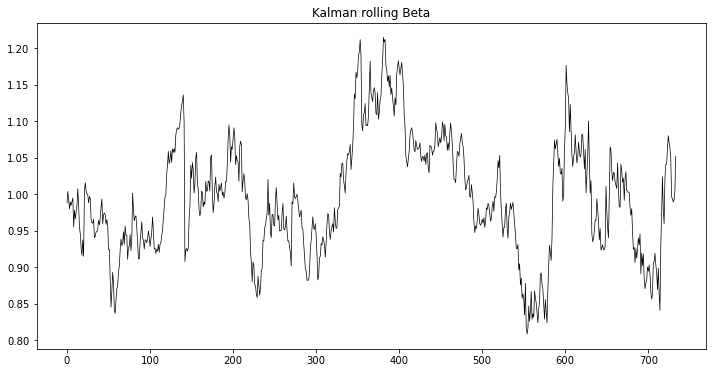

In [59]:
kf_beta = pd.Series(lst)
kf_beta.plot(figsize = (12,6),title = 'Kalman rolling Beta',color = 'black',linewidth = 0.7)

,FB,BABA
Date,,
2018-01-02,181.419998,181.419316
2018-01-03,184.669998,184.669581
2018-01-04,184.330002,184.329634
2018-01-05,186.850006,186.849655
2018-01-08,188.279999,188.279610
...,...,...
2020-11-23,268.429993,268.429730
2020-11-24,276.920013,276.919764
2020-11-25,275.589996,275.589736


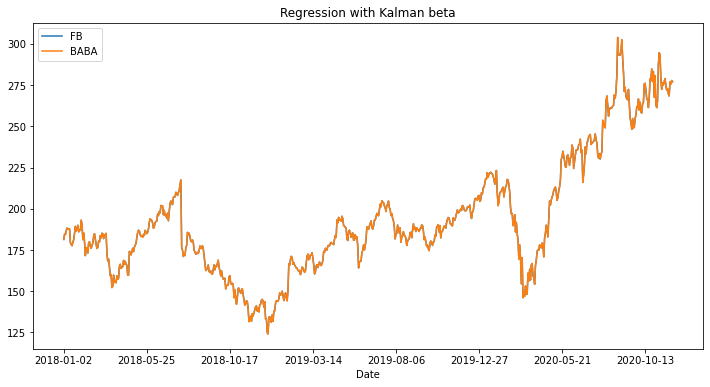

In [60]:
FB = pd.DataFrame(coint_prices.FB)
BABA = pd.DataFrame(coint_prices.BABA)
ls = []
for i in range(len(BABA)):
    ls.append(BABA.iloc[i]*kf_beta[i])
a = pd.DataFrame(ls)
b = FB.join(a)
b.plot(figsize = (12,6), title = 'Regression with Kalman beta')
b

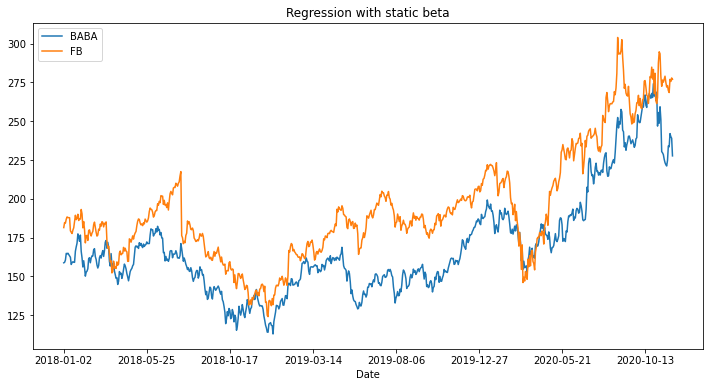

In [61]:
c = (BABA * 0.864299)#.plot(figsize = (12,6),color = 'red')
c = c.join(FB)
c.plot(figsize = (12,6),title = 'Regression with static beta')

In [62]:
from utility import LinearRegression as LR
BABA = pd.DataFrame(coint_prices.BABA)
FB = pd.DataFrame(coint_prices.FB)

model = LR(x = BABA, y = FB)
residuals = pd.DataFrame(model.error.reshape(1,len(FB))[0],
                         index = BABA.index,
                         columns = ['Residual(FB - β·BABA)'])
residuals.head()

,Residual(FB - β·BABA)
Date,
2018-01-02,-2.053493
2018-01-03,0.893997
2018-01-04,-0.923957
2018-01-05,-2.716797
2018-01-08,-0.967018


In [63]:
from utility import VAR

model = VAR(residuals, lag = 1)
B = model.coef.values[0][0]
C = model.coef.values[1][0]
mu = C/(1-B)
tau = 1/252
SSE = np.sum(model.error**2)
sigma_eq = ((SSE*tau/(1-B**2))**0.5).values[0]
Z = 1.03
upper_bound = mu +  Z * sigma_eq
lower_bound = mu -  Z * sigma_eq

====================Cumulative Profit====================
0     30.078133
1     73.563542
2    101.961861
3    136.003606
4    166.313773
5    214.177294
6    240.645979
7    275.766016
dtype: float64


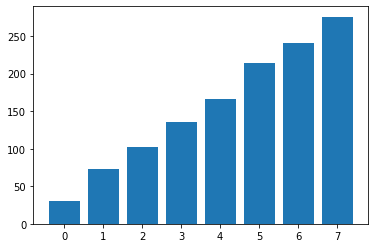

In [64]:
from utility import Backtest2
df = pd.read_csv(datafile, index_col = 'Date')
df['res_past'] = residuals.shift().fillna(0)
df['res'] = residuals
test = Backtest2(df,upper_bound, lower_bound, mu)
trading_rec = test.Signal_generation(daily=False)
test.PL(trading_rec, beta = kf_beta)

In [65]:
trading_rec

,BABA,FB,res_past,res,action
Date,,,,,
2018-03-20,198.949997,168.149994,-20.317073,-28.547278,entry2
2018-06-21,202.210007,201.500000,-0.989369,1.985104,exit
2018-07-24,189.000000,214.669998,24.506539,26.572501,entry1
2018-07-26,194.179993,176.259995,21.641100,-16.314566,exit
2018-11-28,159.339996,136.759995,-24.973207,-25.702385,entry2
2019-04-25,187.880005,193.259995,-2.639378,6.130508,exit
2019-05-30,151.070007,183.009995,25.656716,27.695360,entry1
2019-12-11,204.639999,202.259995,2.876275,0.644858,exit
2020-03-09,197.660004,169.500000,-20.525140,-26.082332,entry2


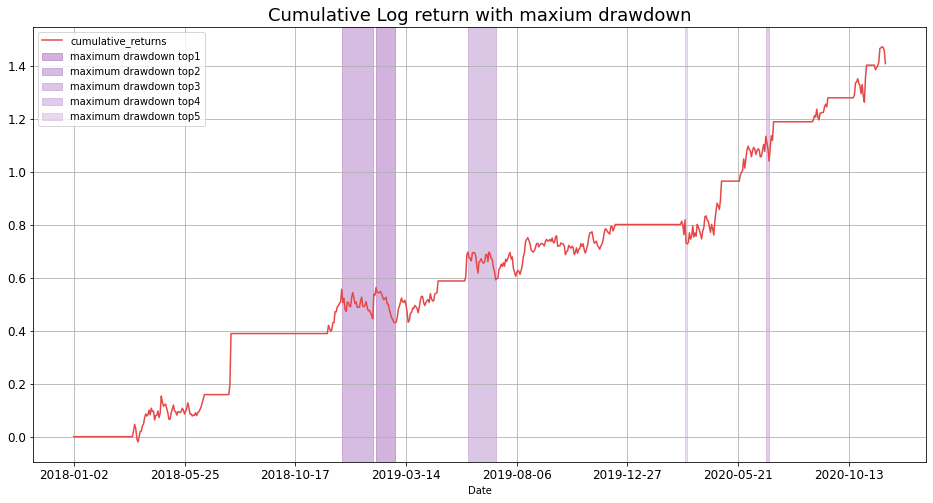

In [66]:
trading_d_rec = test.Signal_generation()
trading_d_rec = test.Returns(trading_d_rec, beta = kf_beta)
test.plot(trading_d_rec)
